## Import libraries and define (reduced) DTFE class

In [1]:
#Load the numpy and scipy libraries
import numpy as np
from scipy.spatial import Delaunay
import numba
from numba import float32, float64, int64
from typing import Union
from matplotlib import pyplot as plt

@numba.jit(nopython=True, nogil=True)
def tetrahedron_volume(sim: int64[:], points: float64[:,:]):
    return abs(np.linalg.det(np.stack((points[sim[1]] - points[sim[0]], 
                                       points[sim[2]] - points[sim[0]],
                                       points[sim[3]] - points[sim[0]])))) / 6

@numba.jit(nopython=True, nogil=True)
def compute_densities(pts: float64[:,:], simps: float64[:,:],
                      m: Union[float64, float64[:]]) -> np.ndarray:
    M = len(pts)
    rho = np.zeros(M, dtype='float64')
    for sim in simps:
        vol = tetrahedron_volume(sim, pts)
        for index in sim:
            rho[index] += vol
    return (3 + 1) * m / rho

@numba.jit(nopython=True, nogil=True)
def compute_gradients(pts, simps, rho):
    N = len(simps)
    Drho = np.zeros((N, 3), dtype='float64')
    Dv   = np.zeros((N, 3, 3), dtype='float64')

    for i, s in enumerate(simps):
        [p0, p1, p2, p3] = pts[s]
        [r0, r1, r2, r3] = rho[s]
        #[v0, v1, v2, v3] = v[s]

        Ainv: float64[:,:] = np.linalg.inv(np.stack((p1 - p0, p2 - p0, p3 - p0)))
        Drho[i] = Ainv @ np.array([r1 - r0, r2 - r0, r3 - r0])
        #Dv[i] = Ainv @ np.stack((v1 - v0, v2 - v0, v3 - v0))
    return Drho

@numba.jit(nopython=True, nogil=True)
def map_affine(a, b, c):
    assert(len(a) == len(b) == len(c))
    result = np.zeros_like(a)
    for i in range(len(a)):
        result[i] = a[i] + b[i] @ c[i]
    return result

#The Delaunay Tesselation Field Estimator 
class DTFE:
    def __init__(self, points, m):
        print("Delaunay Tesselation Field Estimator initialization:")
        #self.velocities = velocities
        print("\t-Evaluate Delaunay tessellation")
        self.delaunay = Delaunay(points)
        
        #Area of a triangle
        
        #The density estimate
        print("\t-Evaluate density estimate")
        self.rho = compute_densities(self.delaunay.points, self.delaunay.simplices, m)
        #The gradients
        print("\t-Evaluate gradients")
        self.Drho = compute_gradients(self.delaunay.points, self.delaunay.simplices,
                                               self.rho)

    #The interpolations
    def density(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.rho[pointIndex], self.Drho[simplexIndex],
                          np.c_[x, y, z] - self.delaunay.points[pointIndex])

# ILLUSTIS TIME

In [2]:
from pathlib import Path
import vaex
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import animation

from scipy.optimize import minimize, curve_fit

from scipy import interpolate
from scipy import ndimage

import illustris_python as il

In [3]:
base_path = "/Users/users/nastase/PROJECT/"
snapshot_number = 133

dm_data = il.snapshot.loadSubset(base_path, snapshot_number,'dm', ['Coordinates', 'Velocities'])
dm_pos_all = dm_data['Coordinates']
dm_vel_all = dm_data['Velocities']

In [4]:
x_min, x_max = 10_000, 25_000
y_min, y_max = 10_000, 25_000
z_min, z_max = 10_000, 25_000

x_filter = (dm_pos_all[:,0] >= x_min) & (dm_pos_all[:,0] <= x_max)
y_filter = (dm_pos_all[:,1] >= y_min) & (dm_pos_all[:,1] <= y_max) 
z_filter = (dm_pos_all[:,2] >= z_min) & (dm_pos_all[:,2] <= z_max)

data_filter = x_filter & y_filter & z_filter

dm_pos_subset = dm_pos_all[data_filter].astype(np.float64)

In [6]:
wid = 750

p=dm_pos_subset
m=np.ones_like(len(dm_pos_all)).astype(np.float64)

In [7]:
%%time
dtfe = DTFE(p, m)

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients
CPU times: user 56.7 s, sys: 2.28 s, total: 58.9 s
Wall time: 1min 58s


In [30]:
L = x_max - x_min
n = 256

X,Y,Z = np.meshgrid(np.linspace(-L/2,L/2,n),np.linspace(-L/2,L/2,n),np.linspace(-wid/2,wid/2,n))

d= dtfe.density(X.flatten(),Y.flatten(),Z.flatten())

In [31]:
den = d.reshape(n,n,n)

In [32]:
dens = den[1:n-1,1:n-1,1:n-1]

In [33]:
np.max((dens[:,:,int(n/2 -1)]))

679.4245595921024

In [34]:
256**3

16777216

In [35]:
len(d)

16777216

In [36]:
np.shape(dens)

(254, 254, 254)

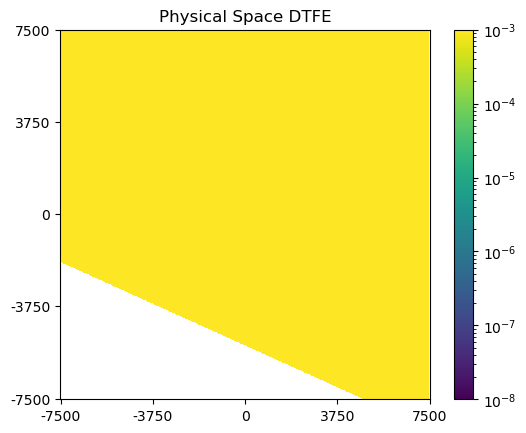

In [37]:
plt.imshow(dens[:,:,int(n/2 -1)],norm="log",origin="lower",vmin =1e-8,vmax = 1e-3)
plt.yticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))
plt.xticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))

plt.title("Physical Space DTFE")
plt.colorbar()
plt.show()